In [12]:
import pathlib

import agama
from astropy.constants import G
import astropy.table as at
from astropy.convolution import convolve, Gaussian2DKernel
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import gala.integrate as gi
from gala.units import galactic
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d
from scipy.interpolate import interp1d
import cmasher as cmr

from config import R0, vc0, gala_pot, agama_pot

agama.setUnits(mass=u.Msun, length=u.kpc, time=u.Myr)

In [2]:
vzlim = (-100, 100)
zlim = (-3, 3)

In [3]:
figure_path = pathlib.Path("../tex/figures/").resolve()

In [4]:
data_path = pathlib.Path("../data").resolve()
# data = at.QTable.read(data_path / "df-toy.fits")
data = at.QTable.read(data_path / "df-qiso.fits")
len(data)

60605380

In [14]:
zmaxish = np.sqrt(data["J"][:, 2] / data["Omega"][:, 2]).to_value(
    u.kpc, u.dimensionless_angles()
)

In [18]:
# Mg/Fe
rng = np.random.default_rng(seed=42)

# Trend and dispersion eyeballed from APOGEE:
# data['MG_FE'] = rng.normal(
#     np.sqrt(0.15) * data['J'][:, 2].value**0.5 + 0.025,
#     0.04
# )
data["MG_FE"] = rng.normal(0.064 * zmaxish + 0.009, 0.05)

In [19]:
null_mask = np.ones(len(data), dtype=bool)
mask = (
    (np.abs(data["R"] - R0) < 0.5 * u.kpc)
    & (np.abs(data["R"] - data["Rg"]) < 0.5 * u.kpc)
    & (np.abs(data["v_R"]) < 15 * u.km / u.s)
)
mask_data = data[mask]
len(mask_data)

3978462

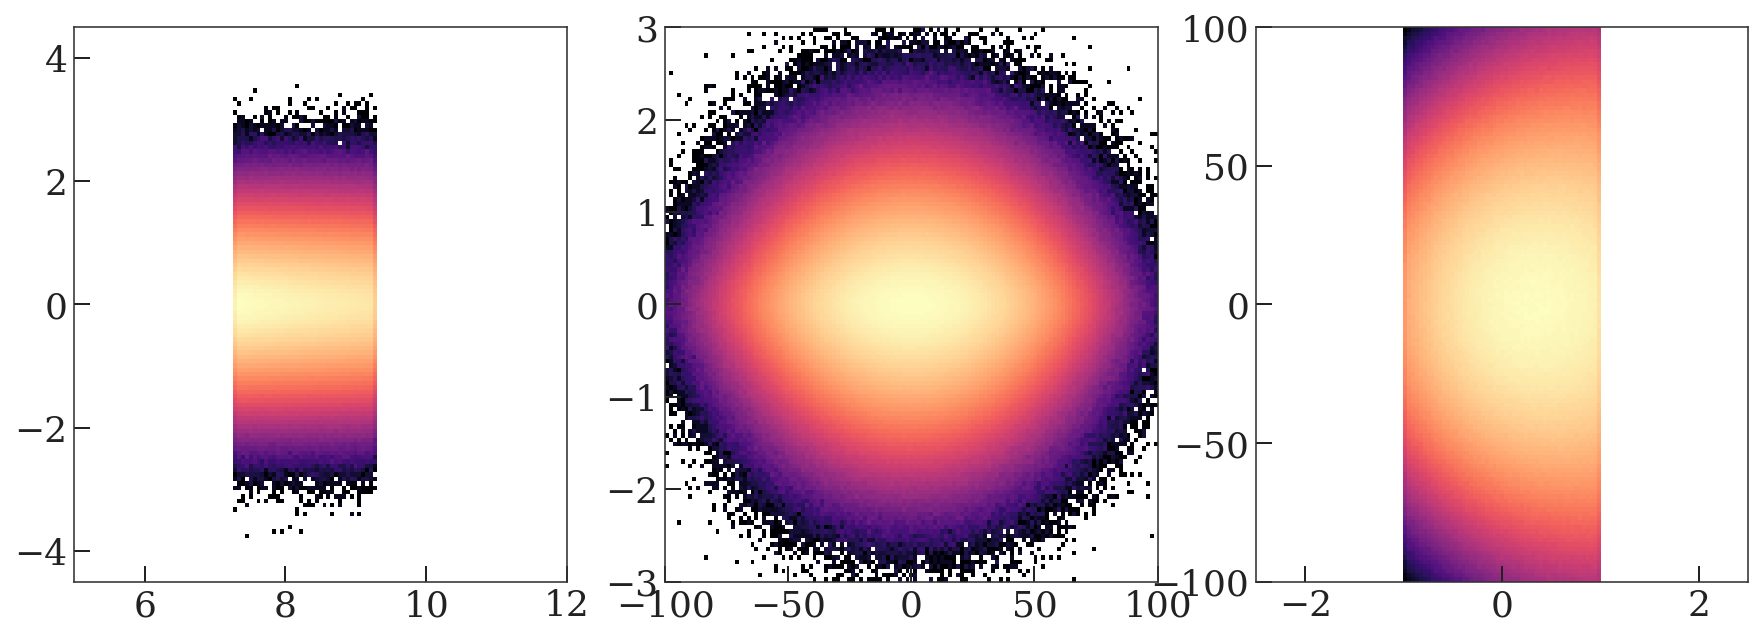

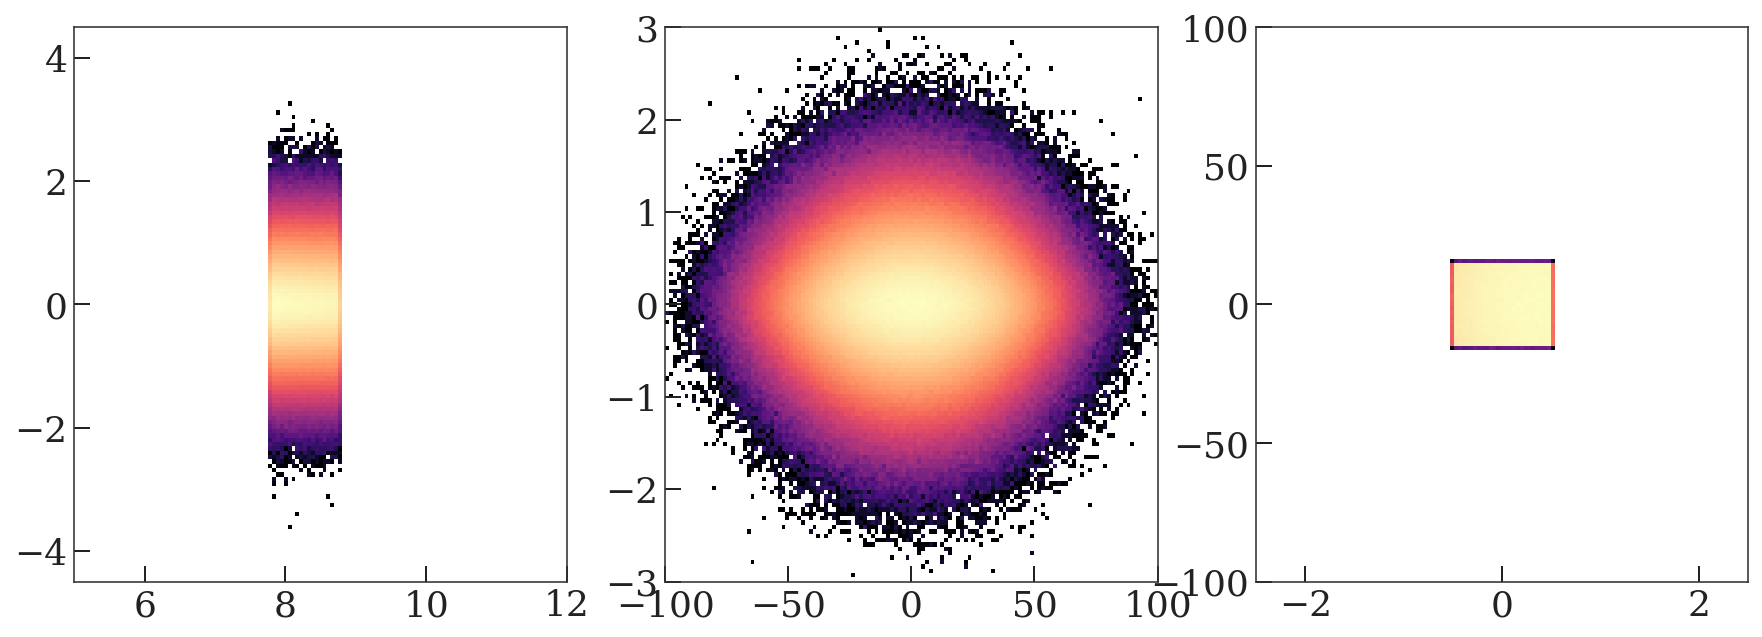

In [20]:
for d in [data, mask_data]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    _ = axes[0].hist2d(
        d["R"].value,
        d["z"].value,
        bins=(np.linspace(5, 12, 128), np.linspace(-4.5, 4.5, 128)),
        norm=mpl.colors.LogNorm(),
    )

    _ = axes[1].hist2d(
        d["v_z"].to_value(u.km / u.s),
        d["z"].to_value(u.kpc),
        bins=(np.linspace(-100, 100, 128), np.linspace(-3, 3, 128)),
        norm=mpl.colors.LogNorm(),
    )

    _ = axes[2].hist2d(
        (d["R"] - d["Rg"]).to_value(u.kpc),
        d["v_R"].to_value(u.km / u.s),
        bins=(np.linspace(-2.5, 2.5, 128), np.linspace(-100, 100, 128)),
        norm=mpl.colors.LogNorm(),
    )

In [21]:
# A grid spaced in Jz:

JR = 0.0 * u.kpc**2 / u.Myr
Jphi = R0 * vc0

Norbits = 8
orbits = []
zvzs = []

Nt = 1024
zeros = np.zeros(Nt)

Jzs = np.linspace(1e-2, np.sqrt(0.13), Norbits) ** 2 * u.kpc**2 / u.Myr
Omzs = []
for Jz in Jzs:
    act = u.Quantity([JR, Jz, Jphi]).to_value(u.kpc**2 / u.Myr)
    torus_mapper = agama.ActionMapper(agama_pot, act, tol=1e-7)
    Omzs.append(torus_mapper.Omegaz)

    T = 2 * np.pi / torus_mapper.Omegaz
    t_grid = np.linspace(0, T, Nt)

    xv0 = torus_mapper([0.0, 0, 0]).T
    #     print(xv0)
    orbit = gala_pot.integrate_orbit(xv0, t=t_grid, Integrator=gi.DOPRI853Integrator)
    zvzs.append((orbit.z.to_value(u.kpc), orbit.v_z.to_value(u.km / u.s)))
    orbits.append(orbit)

In [22]:
# # A grid spaced in z_max:

# JR = 0. * u.kpc**2/u.Myr
# Jphi = R0 * vc0

# tmp_Jzs = np.linspace(1e-3, np.sqrt(0.2), 32) ** 2 * u.kpc**2 / u.Myr
# tmp_zs = np.zeros(tmp_Jzs.size)
# for i, Jz in enumerate(tmp_Jzs):
#     act = u.Quantity([JR, Jz, Jphi]).to_value(u.kpc**2 / u.Myr)
#     torus_mapper = agama.ActionMapper(agama_pot, act, tol=1e-7)
#     xv0 = torus_mapper([0.,np.pi/2,0]).T
#     tmp_zs[i] = xv0[2]

# Jz_interp = interp1d(tmp_zs, tmp_Jzs.value)

# # --

# orbits = []
# zvzs = []

# Nt = 1024
# zeros = np.zeros(Nt)

# Jzs = np.linspace(1e-2, np.sqrt(0.13), Norbits) ** 2 * u.kpc**2 / u.Myr
# Omzs = []
# for Jz in Jz_interp(np.arange(0, 2.6+1e-3, 0.2)) * galactic['diffusivity']:
#     act = u.Quantity([JR, Jz, Jphi]).to_value(u.kpc**2 / u.Myr)
#     torus_mapper = agama.ActionMapper(agama_pot, act, tol=1e-7)
#     Omzs.append(torus_mapper.Omegaz)

#     T = 2 * np.pi / torus_mapper.Omegaz
#     t_grid = np.linspace(0, T, Nt)

#     xv0 = torus_mapper([0.,0,0]).T
#     orbit = gala_pot.integrate_orbit(xv0, t=t_grid, Integrator=gi.DOPRI853Integrator)
#     zvzs.append((orbit.z.to_value(u.kpc), orbit.v_z.to_value(u.km/u.s)))
#     orbits.append(orbit)

In [23]:
Nbins = 151
smooth_kernel = Gaussian2DKernel(2.0)
zvz_data = mask_data

bins = (np.linspace(*vzlim, Nbins), np.linspace(*zlim, Nbins))

H_abun, xe, ye, _ = binned_statistic_2d(
    zvz_data["v_z"].to_value(u.km / u.s),
    zvz_data["z"].to_value(u.kpc),
    zvz_data["MG_FE"],
    bins=bins,
)

H_abun_sm = convolve(H_abun, smooth_kernel, boundary="extend")

xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

ii = len(yc) // 2
abun_grid = H_abun_sm[np.abs(xc).argmin(), ii:]
abun_levels = [np.nanmin(H_abun_sm)]
for zz, _ in zvzs:
    z_grid = yc[ii:]
    jj = np.abs(z_grid - zz.max()).argmin()
    abun_levels.append(abun_grid[jj])

abun_levels = np.sort(np.unique(abun_levels))

A simpler figure:

Text(0, 0.5, 'simulated $[{\\rm Mg}/{\\rm Fe}]$')

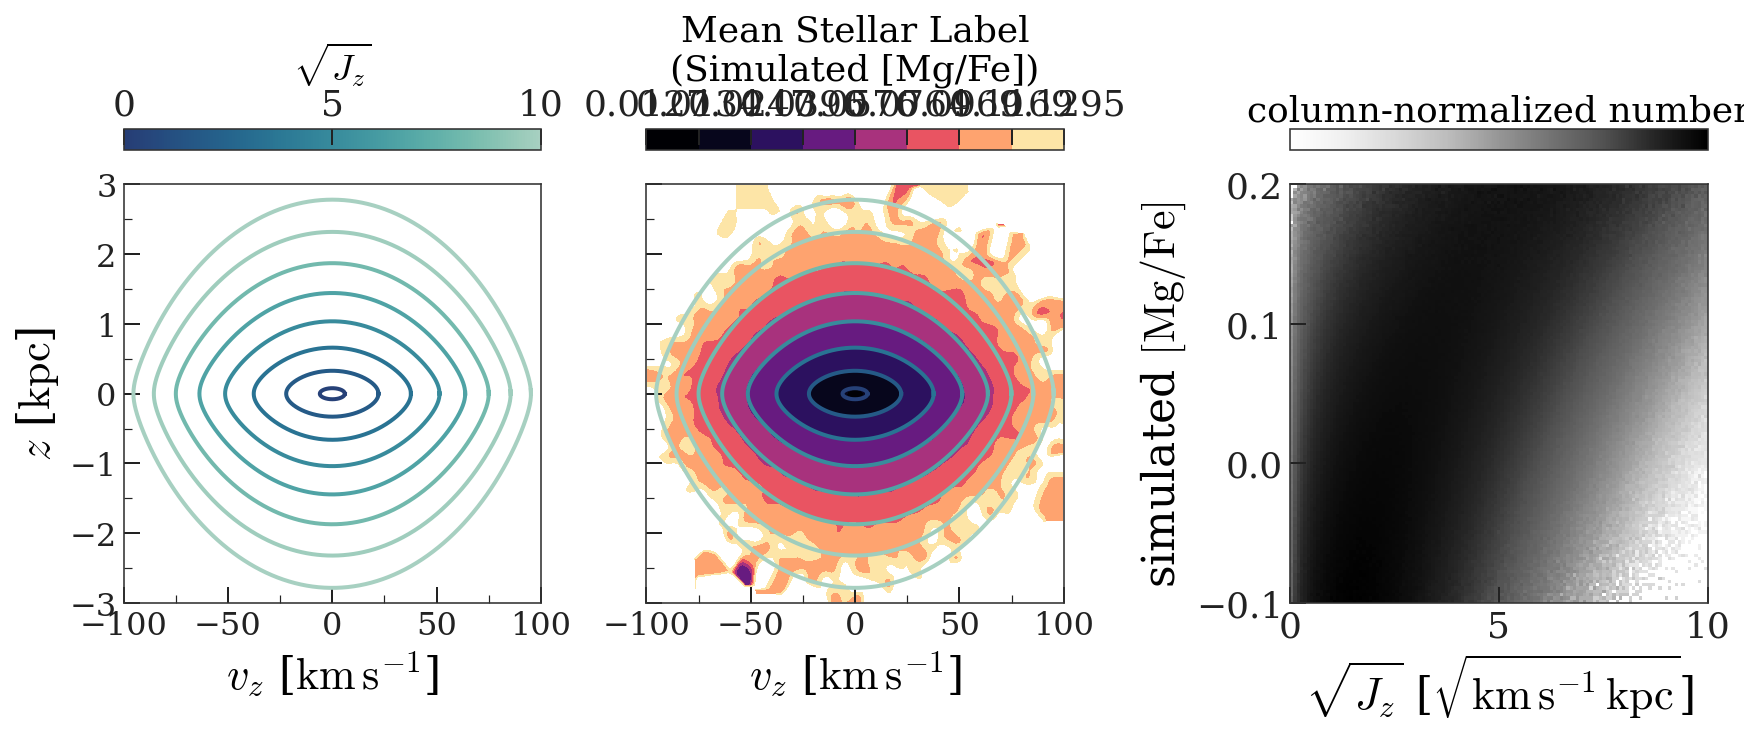

In [24]:
title_size = 18

fig, axes = plt.subplots(
    1,
    3,
    figsize=(3.0 * 4.0, 4.0 + 1.0),
    constrained_layout=True,
)

cmap_Jz = cmr.get_sub_cmap(cmr.ocean, 0.2, 0.8)
# cmap_Jz = cmr.get_sub_cmap(cmr.ember, 0.0, 0.8)
norm_Jz = mpl.colors.Normalize(
    vmin=0.0,
    vmax=10.0,
)

cmap_abun = plt.get_cmap("magma")
norm_abun = mpl.colors.Normalize(vmin=min(abun_levels), vmax=max(abun_levels))

# Orbits:
orbit_axes = axes[:2]
for ax in orbit_axes:
    for (z, vz), Jz in zip(zvzs, Jzs):
        ax.plot(
            vz,
            z,
            marker="",
            ls="-",
            lw=2,
            color=cmap_Jz(norm_Jz(np.sqrt(Jz.to_value(u.km / u.s * u.kpc)))),
        )

sm = plt.cm.ScalarMappable(cmap=cmap_Jz, norm=norm_Jz)
sm.set_array([])
cb = fig.colorbar(sm, ax=axes[0], orientation="horizontal", location="top")
cb.set_label(r"$\sqrt{J_z}$", fontsize=title_size)

cs = axes[1].contourf(
    xc, yc, H_abun_sm.T, levels=abun_levels, cmap=cmap_abun, norm=norm_abun
)
cb = fig.colorbar(cs, ax=axes[1], orientation="horizontal", location="top")
cb.set_label("Mean Stellar Label\n(Simulated [Mg/Fe])", fontsize=title_size)

tmp = np.histogram2d(
    np.sqrt(data["J"][:, 2].to_value(u.km / u.s * u.kpc)),
    data["MG_FE"],
    bins=(np.linspace(0, 10, 128), np.linspace(-0.1, 0.2, 128)),
)
cs = axes[2].pcolormesh(
    tmp[1],
    tmp[2],
    (tmp[0] / tmp[0].sum(axis=0)[None]).T,
    cmap="Greys",
    norm=mpl.colors.LogNorm(),
)
cb = fig.colorbar(cs, ax=axes[2], orientation="horizontal", location="top")
cb.set_label("column-normalized number", fontsize=title_size)
cb.ax.set_xticks([])

# Ticks:
tick_size = 16
for ax in axes[:2]:
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.set_xticks(np.arange(-100, 100 + 1, 50))
    ax.set_xticks(np.arange(-100, 100 + 1, 25), minor=True)

    ax.yaxis.set_tick_params(labelsize=tick_size)
    ax.set_yticks(np.arange(-3, 3 + 1e-3, 1))
    ax.set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

for ax in axes[:2]:
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.set_xticks(np.arange(-100, 100 + 1, 50))
    ax.set_xticks(np.arange(-100, 100 + 1, 25), minor=True)

    ax.yaxis.set_tick_params(labelsize=tick_size)
    ax.set_yticks(np.arange(-3, 3 + 1e-3, 1))
    ax.set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

# Axis sharing:
axes[1].sharex(axes[0])
axes[1].sharey(axes[0])
axes[1].tick_params(labelleft=False)

# Limits:
axes[0].set_xlim(vzlim)
axes[0].set_ylim(zlim)

# # Labels:
for ax in axes[:2]:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")

axes[2].set_xlabel(r"$\sqrt{J_z}$ [$\sqrt{{\rm km}\,{\rm s}^{-1}\,{\rm kpc}}$]")
axes[2].set_ylabel(r"simulated $[{\rm Mg}/{\rm Fe}]$")

# # Titles:
# axes[0, 0].set_title("Orbits", fontsize=title_size)
# axes[1, 1].set_title("Contours of Constant\n Phase-space Density", fontsize=title_size)
# axes[1, 2].set_title("Contours of Constant\n Simulated [Mg/Fe]", fontsize=title_size)

# # fig.suptitle("Simulated Data", fontsize=24, fontweight=600, ha="left", x=0.05)

# # Aspect and padding:
# # for ax in axes.flat:
# #     ax.set_aspect(100.0 / 3)

# fig.get_layout_engine().set(h_pad=0.2)

# # fig.savefig(figure_path / "simulated-orbits-contours.pdf", dpi=250)

TODO: left panel mean label contours, middle orbits, then fourier thing

---

Cheat: exploit the symmetry to get more particles per quadrant!

In [198]:
def get_zvz_reflected_data(data, other_cols=None):
    if other_cols is None:
        other_cols = []

    other = {k: data[k] for k in other_cols}

    new_data = []
    for i in [-1, 1]:
        for j in [-1, 1]:
            new_data.append(
                {"z": i * np.abs(data["z"]), "v_z": j * np.abs(data["v_z"]), **other}
            )

    return at.vstack([at.QTable(x) for x in new_data])

In [199]:
refl_data = get_zvz_reflected_data(mask_data, ["MG_FE"])

In [385]:
Nbins = 151
smooth_kernel = Gaussian2DKernel(2.0)
zvz_data = mask_data

bins = (np.linspace(*vzlim, Nbins), np.linspace(*zlim, Nbins))

H, xe, ye = np.histogram2d(
    zvz_data["v_z"].to_value(u.km / u.s),
    zvz_data["z"].to_value(u.kpc),
    bins=bins,
    density=True,
)
# H /= H.max()

_H, *_ = np.histogram2d(
    refl_data["v_z"].to_value(u.km / u.s),
    refl_data["z"].to_value(u.kpc),
    bins=bins,
    density=True,
)
H_sm = convolve(_H, smooth_kernel, boundary="extend")

H_abun, *_ = binned_statistic_2d(
    zvz_data["v_z"].to_value(u.km / u.s),
    zvz_data["z"].to_value(u.kpc),
    zvz_data["MG_FE"],
    bins=bins,
)

_H_abun, *_ = binned_statistic_2d(
    refl_data["v_z"].to_value(u.km / u.s),
    refl_data["z"].to_value(u.kpc),
    refl_data["MG_FE"],
    bins=bins,
)
H_abun_sm = convolve(_H_abun, smooth_kernel, boundary="extend")

xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

# ii = len(xc) // 2
# dens_grid = H[ii:, np.abs(yc).argmin()]
# levels = [1.]
# for (_, vz) in zvzs:
#     vz_grid = xc[ii:]
#     jj = np.abs(vz_grid - vz[0]).argmin()
#     levels.append(dens_grid[jj])
# levels = np.sort(np.unique(levels))

ii = len(yc) // 2
dens_grid = H_sm[np.abs(xc).argmin(), ii:]
abun_grid = H_abun_sm[np.abs(xc).argmin(), ii:]
levels = [1.0]
abun_levels = [np.nanmin(H_abun_sm)]
for zz, _ in zvzs:
    z_grid = yc[ii:]
    jj = np.abs(z_grid - zz.max()).argmin()
    levels.append(dens_grid[jj])
    abun_levels.append(abun_grid[jj])

levels = np.sort(np.unique(levels))
abun_levels = np.sort(np.unique(abun_levels))

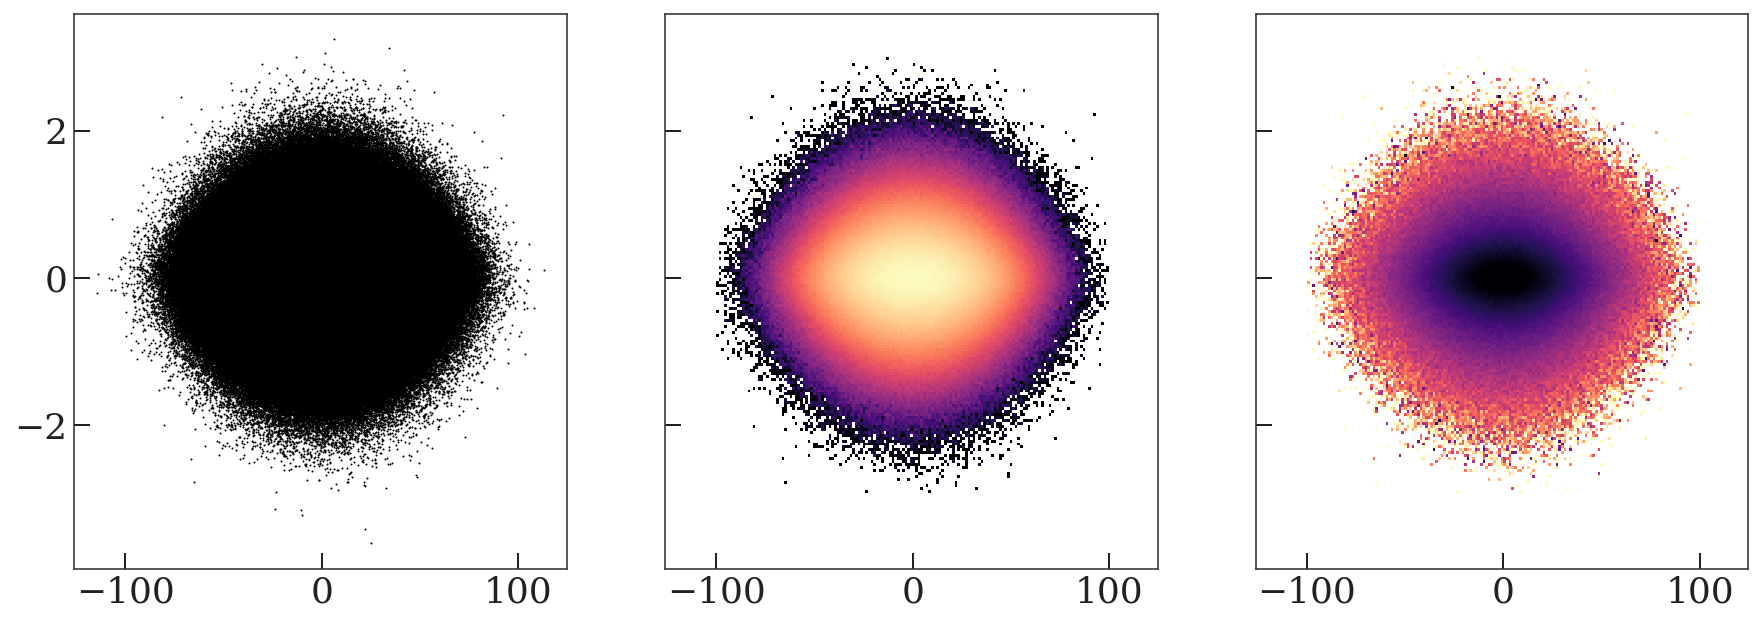

In [386]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axes[0].plot(
    zvz_data["v_z"].to_value(u.km / u.s),
    zvz_data["z"].to_value(u.kpc),
    ls="none",
    marker="o",
    mew=0,
    ms=1,
)
axes[1].pcolormesh(bins[0], bins[1], H.T, norm=mpl.colors.LogNorm())
axes[2].pcolormesh(
    bins[0],
    bins[1],
    H_abun.T,
    vmin=np.nanpercentile(H_abun, 1),
    vmax=np.nanpercentile(H_abun, 95),
)

/tmp/ipykernel_75494/2623997047.py:9: UserWarning: Log scale: values of z <= 0 have been masked
  cs = axes[0].contourf(


(-0.06, 3.0)

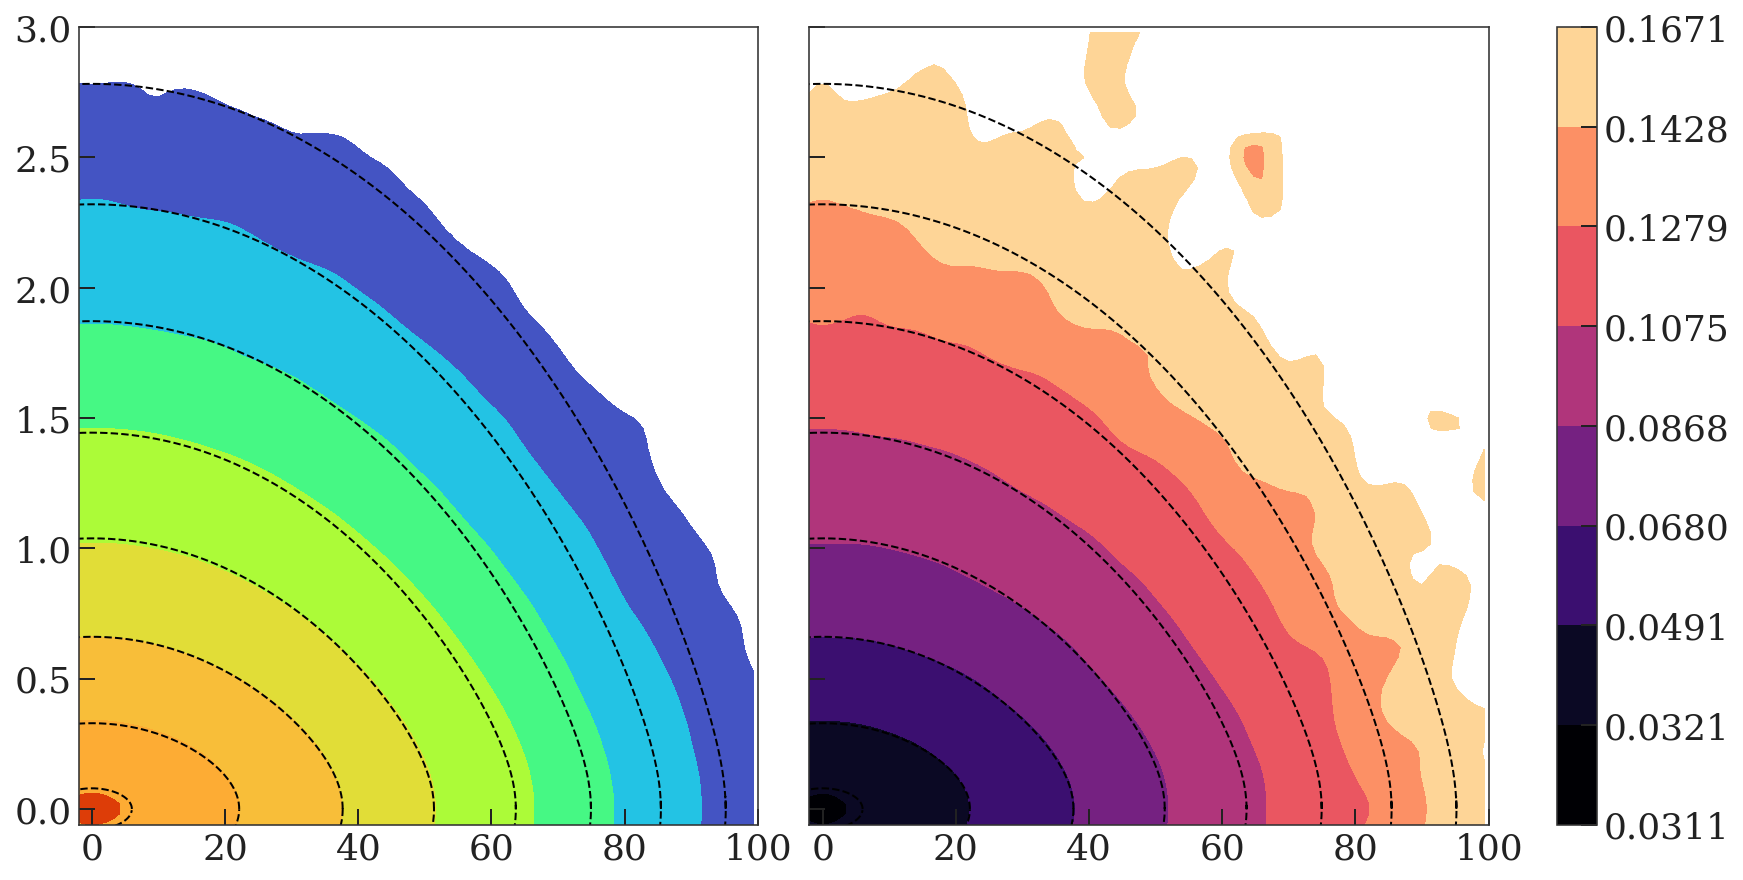

In [387]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True
)

for ax in axes:
    for (z, vz), Jz in zip(zvzs, Jzs):
        ax.plot(vz, z, marker="", ls="--", color="k", lw=1.0)

cs = axes[0].contourf(
    xc,
    yc,
    H_sm.T,
    levels=levels,
    cmap="turbo",
    norm=mpl.colors.LogNorm(),
    zorder=-10,
)

cs = axes[1].contourf(
    xc,
    yc,
    H_abun_sm.T,
    levels=abun_levels[np.isfinite(abun_levels)],
    cmap="magma",
    zorder=-10,
)
fig.colorbar(cs, ax=axes[1])

ax.set_xlim(-0.02 * vzlim[1], vzlim[1])
ax.set_ylim(-0.02 * zlim[1], zlim[1])

/tmp/ipykernel_75494/1960889726.py:42: UserWarning: Log scale: values of z <= 0 have been masked
  axes[1, 1].contourf(xc, yc, H_sm.T, levels=levels, cmap=cmap_dens, norm=norm_dens)


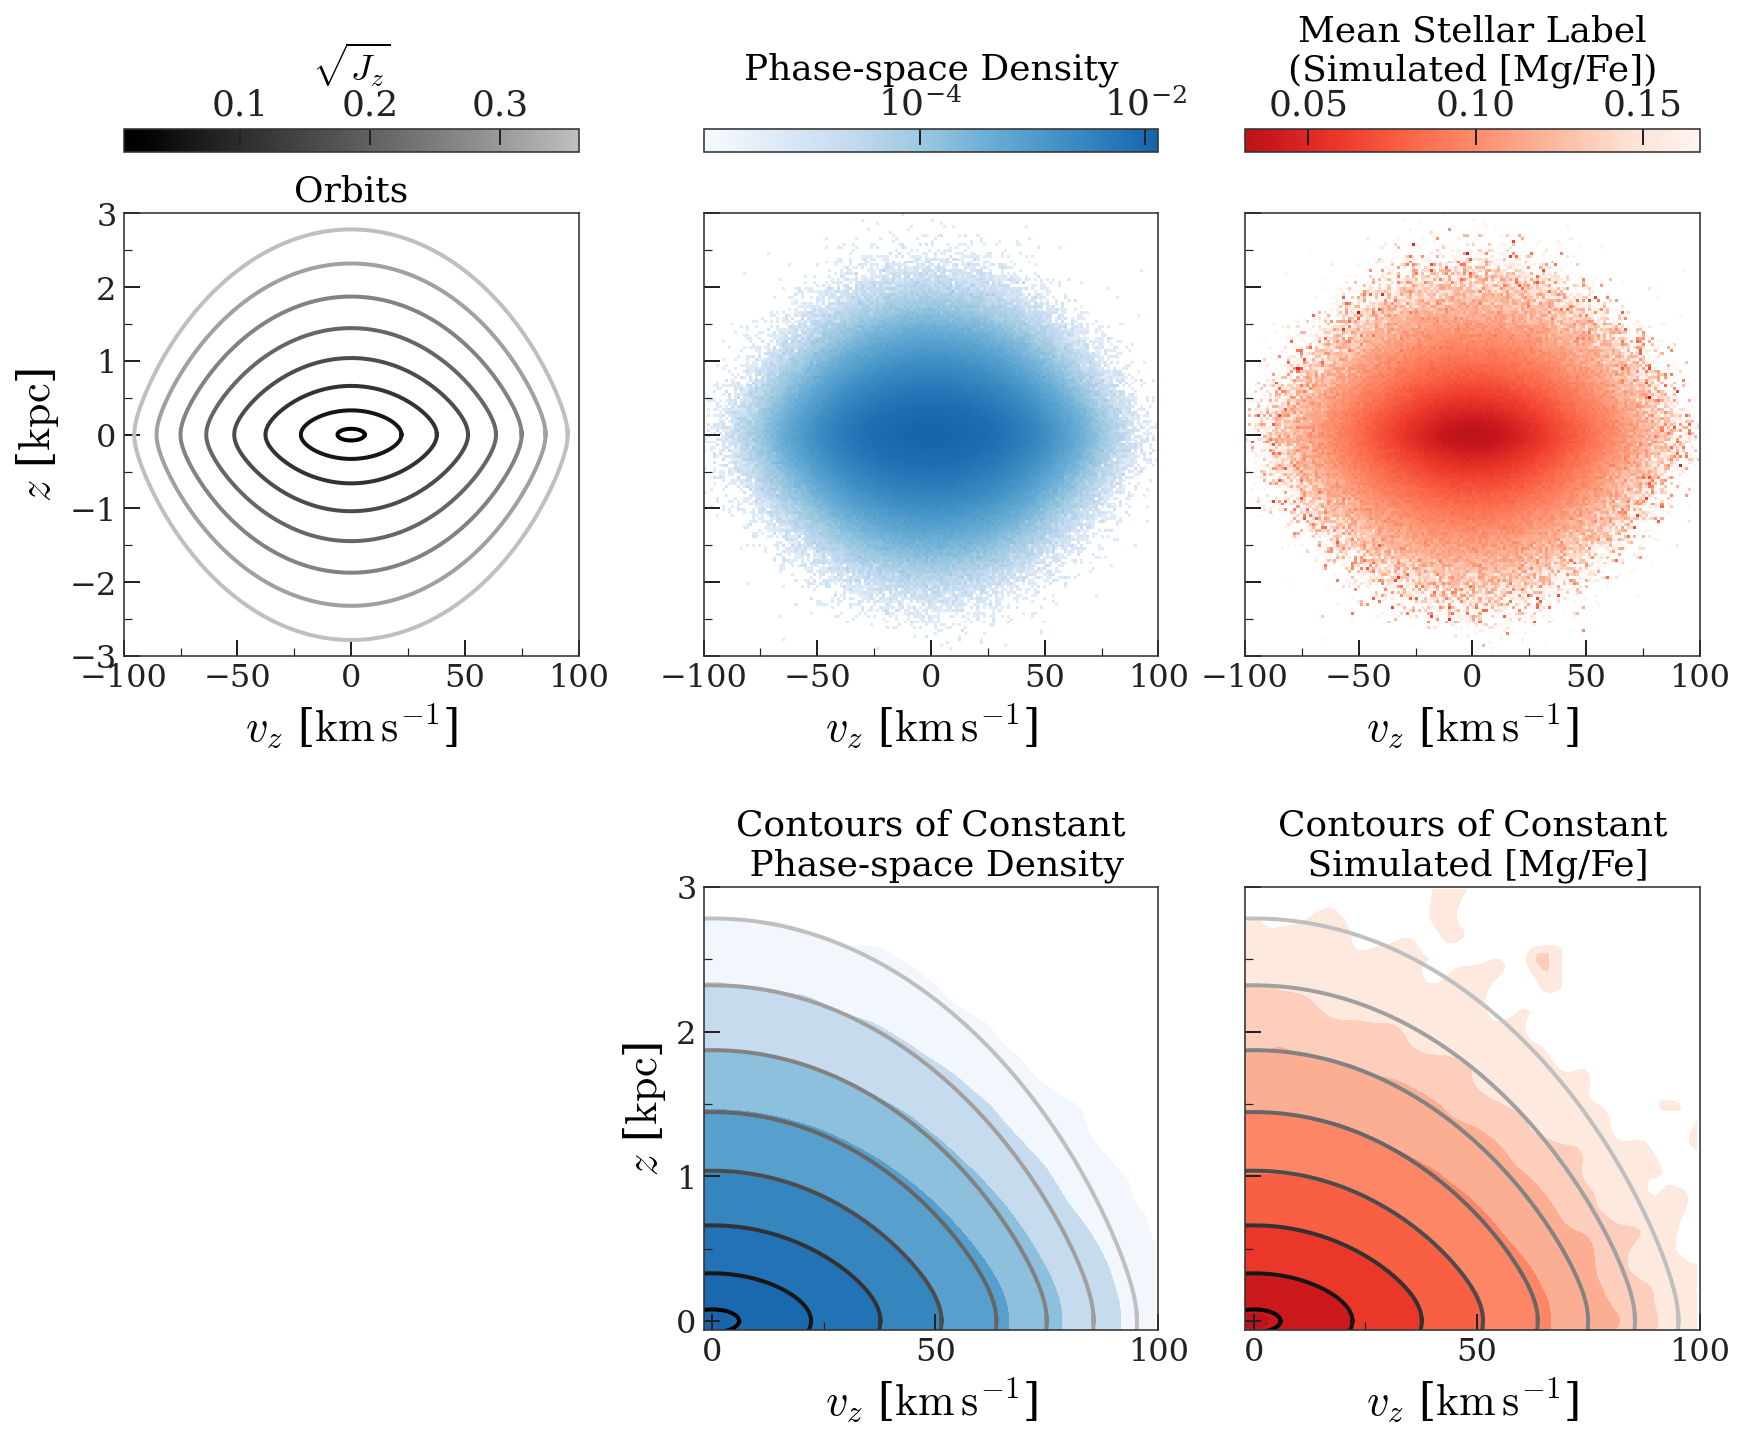

In [443]:
fig, axes = plt.subplots(
    2,
    3,
    figsize=(3.0 * 4.0, 2 * 4.0 + 2.2),
    constrained_layout=True,
)

# cmap_Jz = cmr.get_sub_cmap(cmr.ember, 0.2, 1.)
cmap_Jz = cmr.get_sub_cmap(cmr.neutral, 0.0, 0.8)
norm_Jz = mpl.colors.Normalize(
    vmin=np.sqrt(Jzs.value).min(),
    vmax=np.sqrt(Jzs.value).max(),
)

# cmap_dens = cmr.get_sub_cmap(cmr.jungle_r, 0., 0.8)
cmap_dens = cmr.get_sub_cmap(plt.get_cmap("Blues"), 0.0, 0.8)
norm_dens = mpl.colors.LogNorm(H[H != 0].min() / 4.0, H.max())

# cmap_abun = cmr.get_sub_cmap(cmr.sapphire, 0.2, 1.)
cmap_abun = cmr.get_sub_cmap(plt.get_cmap("Reds_r"), 0.2, 1.0)
norm_abun = mpl.colors.Normalize(vmin=min(abun_levels), vmax=max(abun_levels))

# Orbits:
orbit_axes = [axes[0, 0], axes[1, 1], axes[1, 2]]
for ax in orbit_axes:
    for (z, vz), Jz in zip(zvzs, Jzs):
        ax.plot(
            vz, z, marker="", ls="-", lw=2, color=cmap_Jz(norm_Jz(np.sqrt(Jz.value)))
        )

sm = plt.cm.ScalarMappable(cmap=cmap_Jz, norm=norm_Jz)
sm.set_array([])
cb = fig.colorbar(sm, ax=axes[0, 0], orientation="horizontal", location="top")
cb.set_label(r"$\sqrt{J_z}$", fontsize=title_size)

cs = axes[0, 1].pcolormesh(xc, yc, H.T, cmap=cmap_dens, norm=norm_dens, rasterized=True)
cb = fig.colorbar(cs, ax=axes[0, 1], orientation="horizontal", location="top")
cb.set_label("Phase-space Density", fontsize=title_size)

cs = axes[0, 2].pcolormesh(
    xc, yc, H_abun.T, cmap=cmap_abun, norm=norm_abun, rasterized=True
)
cb = fig.colorbar(cs, ax=axes[0, 2], orientation="horizontal", location="top")
cb.set_label("Mean Stellar Label\n(Simulated [Mg/Fe])", fontsize=title_size)

axes[1, 1].contourf(xc, yc, H_sm.T, levels=levels, cmap=cmap_dens, norm=norm_dens)
axes[1, 2].contourf(
    xc, yc, H_abun_sm.T, levels=abun_levels, cmap=cmap_abun, norm=norm_abun
)

axes[1, 0].set_visible(False)

# Axis sharing:
for ax in axes[0, 1:]:
    ax.sharex(axes[0, 0])
    ax.sharey(axes[0, 0])
    ax.tick_params(labelleft=False)

for ax in axes[1, 2:]:
    ax.sharex(axes[1, 1])
    ax.sharey(axes[1, 1])
    ax.tick_params(labelleft=False)

# Ticks:
tick_size = 16
for ax in axes[0, :]:
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.set_xticks(np.arange(-100, 100 + 1, 50))
    ax.set_xticks(np.arange(-100, 100 + 1, 25), minor=True)

    ax.yaxis.set_tick_params(labelsize=tick_size)
    ax.set_yticks(np.arange(-3, 3 + 1e-3, 1))
    ax.set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

for ax in axes[1, :]:
    ax.xaxis.set_tick_params(labelsize=tick_size)
    ax.set_xticks(np.arange(-100, 100 + 1, 50))
    ax.set_xticks(np.arange(-100, 100 + 1, 25), minor=True)

    ax.yaxis.set_tick_params(labelsize=tick_size)
    ax.set_yticks(np.arange(-3, 3 + 1e-3, 1))
    ax.set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

# Limits:
axes[0, 0].set_xlim(vzlim)
axes[0, 0].set_ylim(zlim)

axes[1, 1].set_xlim(-0.02 * vzlim[1], vzlim[1])
axes[1, 1].set_ylim(-0.02 * zlim[1], zlim[1])
# axes[1, 1].set_xlim(0, vzlim[1])
# axes[1, 1].set_ylim(0, zlim[1])

# Labels:
for ax in axes.flat:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
for ax in [axes[0, 0], axes[1, 1]]:
    ax.set_ylabel(f"$z$ [{u.kpc:latex_inline}]")

# Titles:
title_size = 18
axes[0, 0].set_title("Orbits", fontsize=title_size)
axes[1, 1].set_title("Contours of Constant\n Phase-space Density", fontsize=title_size)
axes[1, 2].set_title("Contours of Constant\n Simulated [Mg/Fe]", fontsize=title_size)

# fig.suptitle("Simulated Data", fontsize=24, fontweight=600, ha="left", x=0.05)

# Aspect and padding:
# for ax in axes.flat:
#     ax.set_aspect(100.0 / 3)

fig.get_layout_engine().set(h_pad=0.2)

fig.savefig(figure_path / "simulated-orbits-contours.pdf", dpi=250)

---

In [324]:
# fig, axes = plt.subplots(
#     2,
#     3,
#     figsize=(3.0 * 4.0, 2 * 4.0 + 1),
#     constrained_layout=True,
# )

# # Orbits:
# orbit_axes = [axes[0, 0], axes[1, 1], axes[1, 2]]
# for ax in orbit_axes:
#     for (z, vz), Jz in zip(zvzs, Jzs):
#         ax.plot(vz, z, marker="", ls="-", lw=1.5, color="k")

# # DF:
# for ax in axes[:, 1]:
#     cs = ax.contourf(
#         xc, yc, H.T, levels=levels, cmap="turbo", norm=mpl.colors.LogNorm()
#     )

# # Mean abundance:
# for ax in axes[:, 2]:
#     cs = ax.contourf(xc, yc, H_abun.T, levels=abun_levels, cmap="magma") # cmap="gist_earth")

# axes[1, 0].set_visible(False)

# # Axis sharing:
# for ax in axes[0, 1:]:
#     ax.sharex(axes[0, 0])
#     ax.sharey(axes[0, 0])
#     ax.tick_params(labelleft=False)

# for ax in axes[1, 2:]:
#     ax.sharex(axes[1, 1])
#     ax.sharey(axes[1, 1])
#     ax.tick_params(labelleft=False)

# # Ticks:
# tick_size = 16
# for ax in axes[0, :]:
#     ax.xaxis.set_tick_params(labelsize=tick_size)
#     ax.set_xticks(np.arange(-100, 100 + 1, 50))
#     ax.set_xticks(np.arange(-100, 100 + 1, 25), minor=True)

#     ax.yaxis.set_tick_params(labelsize=tick_size)
#     ax.set_yticks(np.arange(-3, 3 + 1e-3, 1))
#     ax.set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

# for ax in axes[1, :]:
#     ax.xaxis.set_tick_params(labelsize=tick_size)
#     ax.set_xticks(np.arange(-100, 100 + 1, 50))
#     ax.set_xticks(np.arange(-100, 100 + 1, 25), minor=True)

#     ax.yaxis.set_tick_params(labelsize=tick_size)
#     ax.set_yticks(np.arange(-3, 3 + 1e-3, 1))
#     ax.set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

# # Limits:
# axes[0, 0].set_xlim(vzlim)
# axes[0, 0].set_ylim(zlim)

# # axes[1, 1].set_xlim(-0.02 * vzlim[1], vzlim[1])
# # axes[1, 1].set_ylim(-0.02 * zlim[1], zlim[1])
# axes[1, 1].set_xlim(0, vzlim[1])
# axes[1, 1].set_ylim(0, zlim[1])

# # Labels:
# for ax in axes[-1]:
#     ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
# for ax in [axes[0, 0], axes[1, 1]]:
#     ax.set_ylabel(f"$z$ [{u.kpc:latex_inline}]")

# # Titles:
# title_size = 18
# axes[0, 0].set_title("Orbits", fontsize=title_size)
# axes[0, 1].set_title("Contours of Constant\n Phase-space Density", fontsize=title_size)
# axes[0, 2].set_title("Contours of Constant\n Stellar Label", fontsize=title_size)

# fig.suptitle("Simulated Data", fontsize=24, fontweight=600, ha="left", x=0.05)

# # Aspect and padding:
# for ax in axes.flat:
#     ax.set_aspect(100.0 / 3)

# # fig.get_layout_engine().set(h_pad=0.02)

# # fig.savefig(figure_path / "simulated-orbits-contours.pdf")

TODO: Lower left panel: something about R-z coupling?

Old version:

In [222]:
# fig, axes = plt.subplots(
#     1, 2, figsize=(10.5, 6.3), constrained_layout=True, sharex=True, sharey=True
# )

# # Orbits:
# cm = plt.get_cmap("viridis")
# norm = mpl.colors.Normalize(vmin=0, vmax=np.sqrt(170))
# ax = axes[0]
# for (z, vz), Jz in zip(zvzs, Jzs):
#     ax.plot(
#         vz, z, marker="", ls="-", lw=2, color=cm(norm(np.sqrt(Jz.to_value(u.km / u.s * u.kpc))))
#     )

# ax.set_xlim(vzlim)
# ax.set_ylim(zlim)

# smap = mpl.cm.ScalarMappable(norm=norm, cmap=cm)
# cb = fig.colorbar(smap, ax=axes[0], orientation="horizontal")
# cb.set_label(f"$J_z$ [{u.kpc*u.km/u.s:latex_inline}]")

# # DF:
# ax = axes[1]
# # levels = np.linspace(0, np.max(H), len(Jzs) + 2)
# cs = ax.contourf(xc, yc, H.T, levels=sorted(levels), cmap='Blues', norm=mpl.colors.LogNorm())

# cb = fig.colorbar(cs, ax=ax, orientation="horizontal")
# cb.set_label("scaled density")
# cb.ax.set_xscale('log')
# cb.set_ticklabels([])

# for ax in axes:
#     ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
# axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")

# axes[0].set_title("Orbits")
# axes[1].set_title("Phase-space Density")

# # fig.savefig(figure_path / "illustrate-zvz.pdf")

---

In [223]:
Omega0 = np.sqrt(
    (gala_pot.density([1, 0, 0] * R0)[0] * (2 * np.pi * G)).decompose()
).decompose(galactic)

In [224]:
def pi_ticklabel(val, denomlim=10):
    """
    format label properly
    for example: 0.6666 pi --> 2π/3
               : 0      pi --> 0
               : 0.50   pi --> π/2
    """
    from fractions import Fraction

    minus = "-" if val < 0 else ""
    val = abs(val)
    ratio = Fraction(val / np.pi).limit_denominator(denomlim)
    n, d = ratio.numerator, ratio.denominator

    pi = r"\pi"
    fmt2 = f"{d:d}"
    if n == 0:
        fmt1 = "0"
    elif n == 1:
        fmt1 = pi
    else:
        fmt1 = f"{n:d}{pi}"

    txt = fmt1 if d == 1 else f"{fmt1}/{fmt2}"

    return f"${minus}{txt}$"

In [225]:
def get_X(th, m_max=8):
    arrs = [np.ones_like(th)]
    for m in range(2, m_max + 1, 2):
        arrs.append(np.cos(m * th))
    return np.stack(arrs).T

TODO: dotted to solid gray, only one ellipse on left

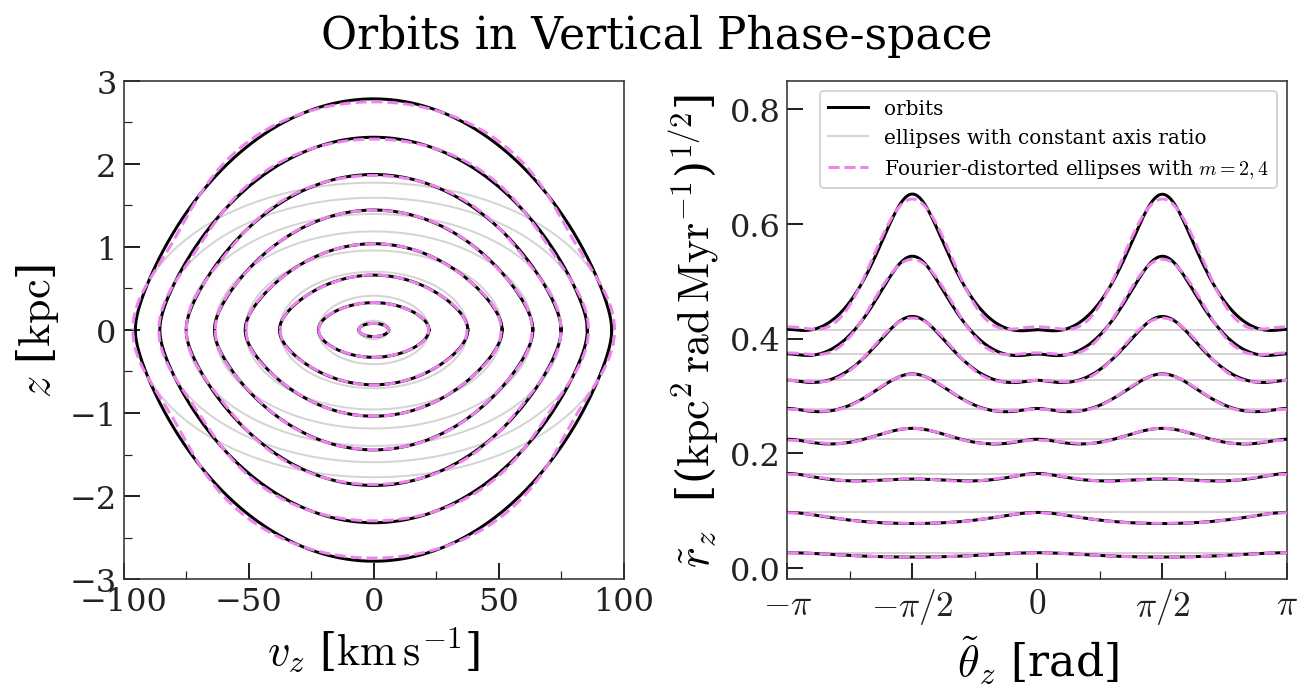

In [436]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(9, 4.75),
    constrained_layout=True,
)

ax = axes[0]
orbit_linestyle = dict(marker="", ls="-", lw=1.5, color="k", zorder=10, label="orbits")
ellip_linestyle = dict(
    marker="",
    ls="-",
    lw=1.0,
    alpha=0.5,
    color="#aaaaaa",
    zorder=-10,
    label="ellipses with constant axis ratio",
)
fourier_linestyle = dict(
    marker="",
    ls="--",
    lw=1.5,
    color="violet",
    zorder=20,
    label="Fourier-distorted ellipses with $m={2,4}$",
)
for orbit, Jz in zip(orbits, Jzs):
    # ax.plot(vz, z, **orbit_linestyle)
    axes[0].plot(orbit.v_z.to_value(u.km / u.s), orbit.z.value, **orbit_linestyle)

    rzp = np.sqrt(orbit.z**2 * Omega0 + orbit.v_z**2 / Omega0)
    thp = np.arctan2(orbit.z * np.sqrt(Omega0), orbit.v_z / np.sqrt(Omega0))
    idx = np.argsort(thp)
    thp = thp[idx]
    rzp = rzp[idx]
    axes[1].plot(thp, rzp.decompose(galactic).value, **orbit_linestyle)

    # Ellipses with constant aspect ratio:
    idx = np.abs(thp - 0 * u.rad).argmin()
    th_grid = np.linspace(-np.pi, np.pi, 1024)
    z_grid = (rzp[idx] / np.sqrt(Omega0)).to(u.kpc) * np.sin(th_grid)
    vz_grid = (rzp[idx] * np.sqrt(Omega0)).to(u.km / u.s) * np.cos(th_grid)
    axes[0].plot(vz_grid, z_grid, **ellip_linestyle)
    axes[1].plot(
        th_grid,
        np.full_like(th_grid, rzp[idx].decompose(galactic).value),
        **ellip_linestyle,
    )

    # Fourier exp:
    X = get_X(thp.to_value(u.rad), m_max=4)
    coeff = np.linalg.inv((X.T @ X)) @ X.T @ rzp.decompose(galactic).value

    pred_thp = thp
    pred_rzp = (X @ coeff) * (galactic["length"] ** 2 / galactic["time"]) ** 0.5
    pred_vz = (pred_rzp * np.sqrt(Omega0)).to_value(u.km / u.s) * np.cos(thp)
    pred_z = (pred_rzp / np.sqrt(Omega0)).to_value(u.kpc) * np.sin(thp)
    axes[0].plot(
        pred_vz,
        pred_z,
        **fourier_linestyle,
    )
    axes[1].plot(pred_thp, pred_rzp, **fourier_linestyle)

    for style in [orbit_linestyle, ellip_linestyle, fourier_linestyle]:
        style.pop("label", None)


axes[1].legend()

# Labels:
axes[0].set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")
axes[1].set_xlabel(r"$\tilde{\theta}_z$ [rad]")
rz2_unit = u.kpc**2 * u.rad / u.Myr
axes[1].set_ylabel(
    r"$\tilde{r}_z$ " + f" [({rz2_unit.to_string(format='latex_inline')})$^{{1/2}}$]"
)

# Ticks:
axes[0].xaxis.set_tick_params(labelsize=tick_size)
axes[0].set_xticks(np.arange(-100, 100 + 1, 50))
axes[0].set_xticks(np.arange(-100, 100 + 1, 25), minor=True)
axes[0].yaxis.set_tick_params(labelsize=tick_size)
axes[0].set_yticks(np.arange(-3, 3 + 1e-3, 1))
axes[0].set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

axes[1].xaxis.set_tick_params(labelsize=1.1 * tick_size)
_ticks = np.arange(-1, 1 + 1e-3, 0.5) * np.pi
axes[1].set_xticks(_ticks)
axes[1].set_xticklabels([pi_ticklabel(val) for val in _ticks])
axes[1].set_xticks(np.arange(-1, 1 + 1e-3, 0.25) * np.pi, minor=True)
axes[1].yaxis.set_tick_params(labelsize=tick_size)
# axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 1))
# axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

# Limits:
axes[0].set_xlim(vzlim)
axes[0].set_ylim(zlim)
axes[1].set_xlim(-np.pi, np.pi)
axes[1].set_ylim(-0.02, 0.85)

# Titles:
title_size = 18
# axes[0].set_title("Orbits", fontsize=title_size)
fig.suptitle("Orbits in Vertical Phase-space", fontsize=22)

# Aspect and padding:
# axes[0].set_aspect(100.0 / 3)

fig.savefig(figure_path / "simulated-orbits-fourier.pdf")

In empaf:
$$
r_z = \tilde{r}_z \, \left(1 + \sum_m e_m(\tilde{r}_z) \, \cos(m\,\tilde{\theta}_z)\right)
$$

Here:
$$
\tilde{r}_z = a + \sum_m b \, \cos(m\,\tilde{\theta}_z) \\
a = r_z\\
b = r_z \, e_m(r_z)\\
\tilde{r}_z = r_z \, \left(1 + \sum_m e_m(r_z) \, \cos(m\,\tilde{\theta}_z) \right) \\
$$

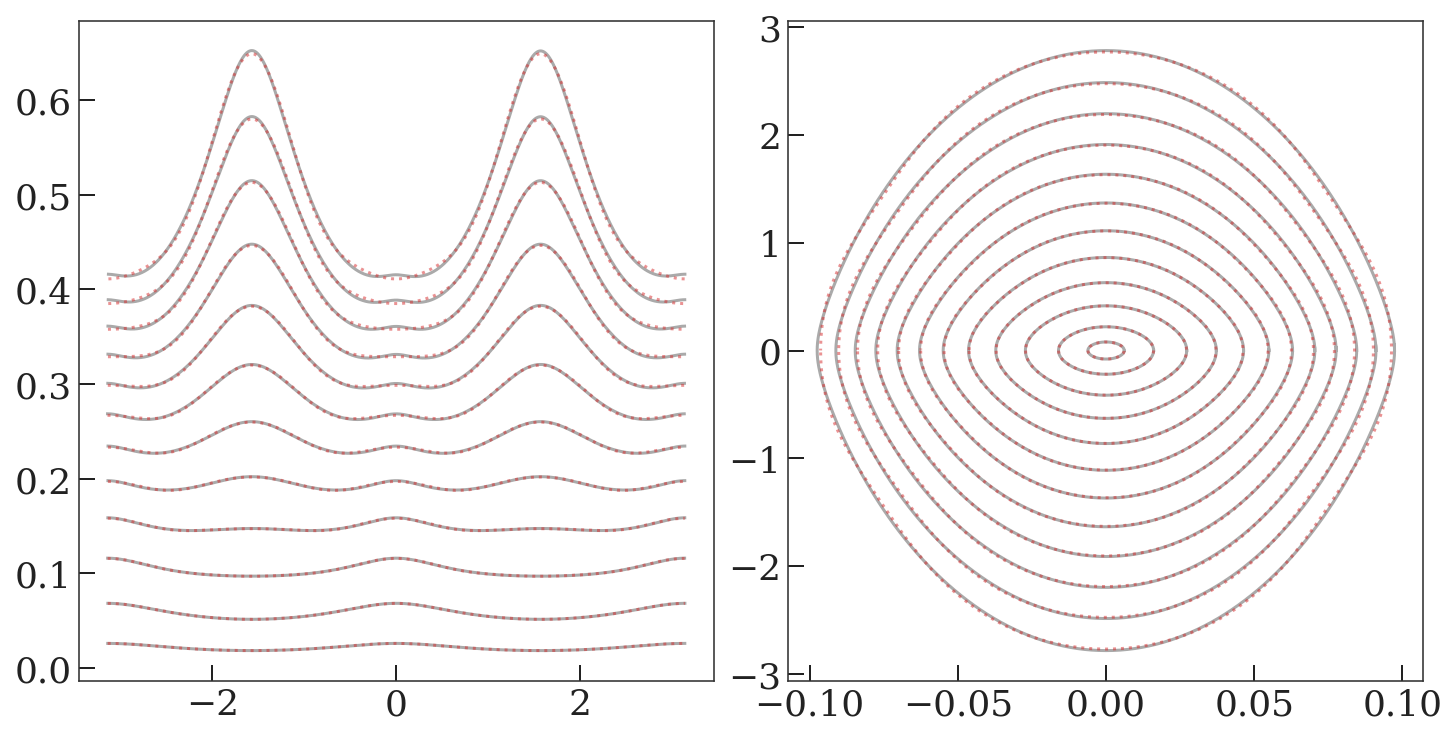

In [104]:
m_max = 6

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

rzps = []
coeffs = []
for orbit, Jz in zip(orbits, Jzs):
    rzp = (
        np.sqrt(orbit.z**2 * Omega0 + orbit.v_z**2 / Omega0)
        .decompose(galactic)
        .value
    )
    thp = np.arctan2(orbit.z * np.sqrt(Omega0), orbit.v_z / np.sqrt(Omega0))
    idx = np.argsort(thp)
    axes[0].plot(thp[idx], rzp[idx], marker="", color="#aaaaaa")
    axes[1].plot(
        orbit.v_z.decompose(galactic).value,
        orbit.z.decompose(galactic).value,
        marker="",
        color="#aaaaaa",
    )

    X = get_X(thp, m_max=m_max)
    coeff = np.linalg.inv((X.T @ X)) @ X.T @ rzp
    coeffs.append(coeff)
    rzps.append(rzp)

    pred_thp = thp[idx]
    pred_rzp = X[idx] @ coeff
    axes[0].plot(
        pred_thp,
        pred_rzp,
        marker="",
        ls=":",
        alpha=0.5,
        color="tab:red",
        zorder=100,
    )

    axes[1].plot(
        pred_rzp * np.sqrt(Omega0.value) * np.cos(thp[idx]),
        pred_rzp / np.sqrt(Omega0.value) * np.sin(thp[idx]),
        marker="",
        ls=":",
        alpha=0.5,
        color="tab:red",
        zorder=100,
    )

coeffs = np.array(coeffs)
rzps = np.array(rzps)

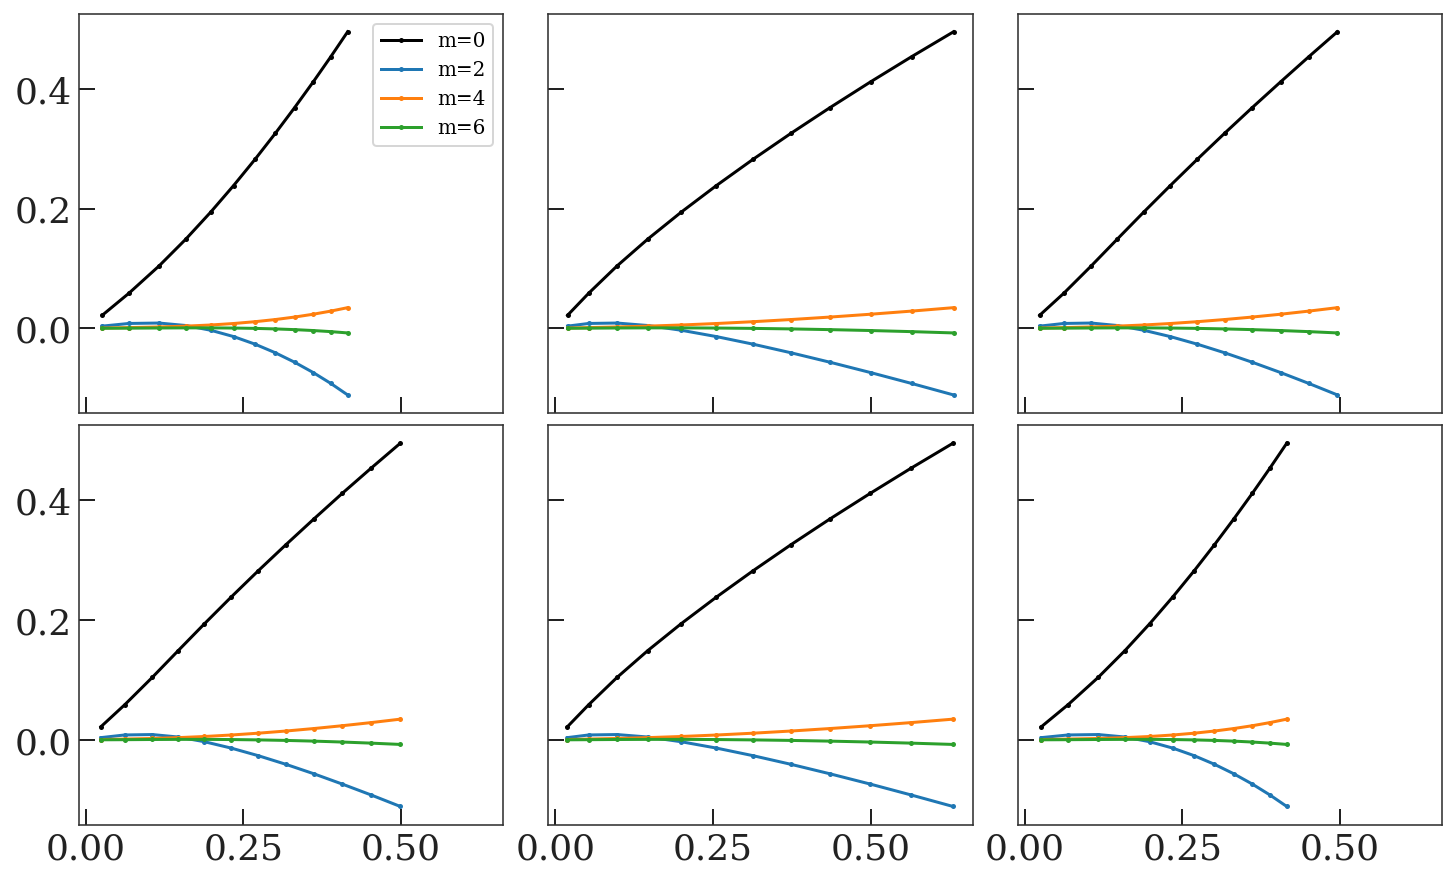

In [105]:
fig, axes = plt.subplots(
    2, 3, figsize=(10, 6), sharex=True, sharey=True, constrained_layout=True
)
for j, i in enumerate(np.linspace(0, rzps.shape[1] - 1, axes.size).astype(int)):
    for k, m in enumerate(range(0, m_max + 1, 2)):
        axes.flat[j].plot(rzps[:, i], coeffs[:, k], label=f"m={m}")
    axes.flat[0].legend(loc="best")